<div>
<img align="right" src="pictures/Logo.png" width="200"/>
</div>

# Persistent topological spectra tested on a real device

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [36]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import Session, Sampler
import qtda_module as qtda  # your own QTDAalgorithm class from the paper
from qiskit.visualization import plot_histogram
# from qiskit import IBMQ
from qiskit_aer import Aer
from qiskit.compiler import transpile

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2  as Sampler
# provider = IBMQ.load_account()
# accountProvider = IBMQ.get_provider(hub='ibm-q-fraunhofer',group = 'fhg-all',project = 'ticket')
# backend = accountProvider.get_backend('ibmq_brooklyn')


service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")

# 1) Build your 9-qubit QTDA circuit exactly as before
n_vertices      = 3
num_eval_qubits = 3
S0 = [(0,0,1), (0,1,0), (1,0,0)]
S1 = [(1,0,1), (0,1,1), (1,1,0)]
S2 = []

state_dict = {0: S0, 1: S1, 2: S2}
k = 1  # looking at 1st Betti

qc = qtda.QTDAalgorithm(num_eval_qubits, k, state_dict)
# Add a 3-bit classical register for measuring the eval qubits
qc.add_register(ClassicalRegister(num_eval_qubits, name='c_eval'))
for i, q in enumerate(qc.eval_qubits):
    qc.measure(q, q)  # measure eval[i] → classical[i]


/tmp/ipykernel_8748/1511678000.py:16: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


In [38]:
# 2) Transpile once (Sabre + opt_level=3). Let the transpiler choose a
#    connected patch of 9 qubits out of the 127 with minimal SWAPs.
#
#    IMPORTANT: we do *not* re-transpile again after mitigation. We use
#    the exact same circuit shape (so the measurement‐calibration matrix
#    still applies) when we run at x1, x2, x3 noise levels for ZNE.
#
transpiled_qc = transpile(
    qc,
    backend=backend,
    basis_gates=['sx','rz','x','cx'],
    optimization_level=3,
    routing_method='sabre',
    seed_transpiler=42
)


In [ ]:
# 3) Run the *raw* circuit with no mitigation
from qiskit_ibm_runtime import Sampler, Session

shots = 8192
with Session(backend=backend) as sess:
    sampler_raw = Sampler(
        session=sess,
        options={
            "shots": shots,
            "resilience_level": 0,   # raw counts, no mitigation
            "transpilation": {
                # *Must* reuse the same transpiled_qc above. Otherwise the
                #  calibration data for readout‐mit is invalid.
                "initial_layout": transpiled_qc.layout,
                "basis_gates": ['sx','rz','x','cx'],
                "routing_method": "sabre",
                "optimization_level": 3,
                "seed_transpiler": 42
            }
        }
    )
    job_raw    = sampler_raw.run([transpiled_qc])
    result_raw = job_raw.result()
    quasi_raw  = result_raw.quasi_dists[0]  # raw quasi distribution is identical to counts
    p000_raw   = quasi_raw.get(0, 0.0)
    beta1_raw  = len(S1) * p000_raw
    print(f"→ Unmitigated β₁ = {beta1_raw:.4f}")

ValidationError: 3 validation errors for SamplerOptions
shots
  Unexpected keyword argument [type=unexpected_keyword_argument, input_value=8192, input_type=int]
    For further information visit https://errors.pydantic.dev/2.9/v/unexpected_keyword_argument
resilience_level
  Unexpected keyword argument [type=unexpected_keyword_argument, input_value=0, input_type=int]
    For further information visit https://errors.pydantic.dev/2.9/v/unexpected_keyword_argument
transpilation
  Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'initial_layout': Transp..., 'seed_transpiler': 42}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/unexpected_keyword_argument

In [ ]:
# 4) Run *with* readout‐error mitigation (level 1)
with Session(backend=backend) as sess:
    sampler_ro = Sampler(
        session=sess,
        options={
            "shots": shots,
            "resilience_level": 1,   # readout‐error correction only
            "transpilation": {
                "initial_layout": transpiled_qc.calibrations.layout,
                "basis_gates": ['sx','rz','x','cx'],
                "routing_method": "sabre",
                "optimization_level": 3,
                "seed_transpiler": 42
            }
        }
    )
    job_ro    = sampler_ro.run([transpiled_qc])
    result_ro = job_ro.result()
    quasi_ro  = result_ro.quasi_dists[0]
    p000_ro   = quasi_ro.get(0, 0.0)
    beta1_ro  = len(S1) * p000_ro
    print(f"→ Readout‐mitigated β₁ = {beta1_ro:.4f}")

In [ ]:
# 5) Run *with* readout + ZNE (level 2)
with Session(backend=backend) as sess:
    sampler_zne = Sampler(
        session=sess,
        options={
            "shots": shots,
            "resilience_level": 2,  # 1 = RO, 2 = RO+ZNE, 3 = RO+TWIRL etc.
            "transpilation": {
                "initial_layout": transpiled_qc.calibrations.layout,
                "basis_gates": ['sx','rz','x','cx'],
                "routing_method": "sabre",
                "optimization_level": 3,
                "seed_transpiler": 42
            }
        }
    )
    job_zne    = sampler_zne.run([transpiled_qc])
    result_zne = job_zne.result()
    quasi_zne  = result_zne.quasi_dists[0]
    p000_zne   = quasi_zne.get(0, 0.0)
    beta1_zne  = len(S1) * p000_zne
    print(f"→ ZNE‐mitigated β₁ ≈ {beta1_zne:.4f}")

In [17]:
import numpy as np
import qtda_module as qtda
from qiskit.visualization import plot_histogram
# from qiskit import IBMQ
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit_aer import Aer
from qiskit.compiler import transpile

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2  as Sampler

In this notebook we test the quantum algorithm for the persistent topological analysis on real quantum hardware.

In [18]:
# provider = IBMQ.load_account()
# accountProvider = IBMQ.get_provider(hub='ibm-q-fraunhofer',group = 'fhg-all',project = 'ticket')
# backend = accountProvider.get_backend('ibmq_brooklyn')


service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")


/tmp/ipykernel_8748/1310481728.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


## Quantum circuit for the topological analysis

As an example, the quantum circuit for the topological analysis of a simplicial complex of three abstract points is used.
<div>
<img src="pictures/Simplex_real-device.png" width="200"/>
</div>

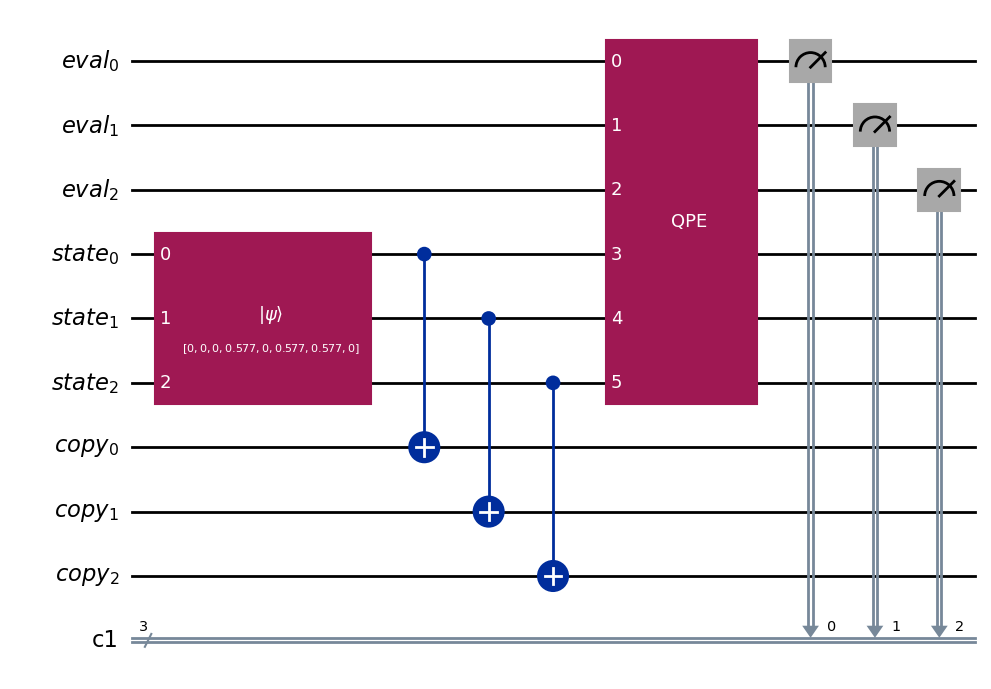

In [19]:
n_vertices = 3 # number of vertices
num_eval_qubits = 3 # number of evaluation qubits

S0 = [(0,0,1),(0,1,0), (1,0,0)] # points
S1 = [(1,0,1),(0,1,1),(1,1,0)] # lines
S2 = []

state_dict = {0: S0, 1: S1, 2: S2}
k = 1 # order of the combinatorial Laplacian
qc = qtda.QTDAalgorithm(num_eval_qubits, k, state_dict)

qc.add_register(ClassicalRegister(num_eval_qubits)) # adding a classical register for measuring
for q in qc.eval_qubits: # measure all evaluation qubits
    qc.measure(q,q)
qc.draw('mpl')

The circuit is transpiled to the basis gates set `'id', 'rz', 'sx', 'x' and 'cx'`, with the layout method `sabre` (reduces full routing cost) and optimization level 3 (heavy optimization).
The transpilation is done for an arbitrary backend and the `ibmq_brooklyn`.

In [20]:
qcc = transpile(qc, basis_gates=['id', 'rz', 'sx', 'x', 'cx'], layout_method='sabre',optimization_level=3)

In [21]:
qa = transpile(qc, backend=backend, basis_gates=['id', 'rz', 'sx', 'x', 'cx'],layout_method='sabre',optimization_level=3)

KeyboardInterrupt: 

In [22]:
qa = transpile(
    qc,
    backend       = backend,      # must be the identical object you
                                  # will hand to Sampler
    optimization_level = 3,
    routing_method     = "sabre", # let Sabre insert SWAPs
    seed_transpiler    = 42
)

In [23]:
from qiskit_ibm_runtime.utils import validations
validations.validate_isa_circuits([qa], backend.target)   # raises if still illegal

For quantum computers in the NISQ era, a high circuit depth amplifies the errors and is undesired. Because of the high circuit depth, we do expect a high noise level.

In [ ]:
qa.depth() # depth of quantum one

1850

In [25]:
qcc.depth() # depth of an arbitrary backend

771

In [26]:
print(qa.count_ops())       # gate counts
print(qa.num_qubits)        # how many qubits the transpiled circuit uses
print(qa.draw('text'))      # skim the CX lines – every pair must appear
                            # in the device coupling map

OrderedDict([('rz', 1637), ('sx', 940), ('ecr', 499), ('x', 128), ('reset', 3), ('measure', 3)])
127
global phase: 3.214
              ┌─────────┐    ┌────┐      ┌────────┐                          »
 eval_1 -> 56 ┤ Rz(π/2) ├────┤ √X ├──────┤ Rz(-π) ├──────────────────────────»
              ├─────────┴┐   ├────┤    ┌─┴────────┴┐                         »
 copy_1 -> 57 ┤ Rz(-π/2) ├───┤ √X ├────┤ Rz(3.097) ├─────────────────────────»
              ├─────────┬┘   ├────┤    └───────────┘                         »
 eval_0 -> 58 ┤ Rz(π/2) ├────┤ √X ├──────────────────────────────────────────»
              ├─────────┤    ├────┤   ┌─────────────┐   ┌────┐   ┌──────────┐»
 eval_2 -> 59 ┤ Rz(π/2) ├────┤ √X ├───┤ Rz(-2.7262) ├───┤ √X ├───┤ Rz(-π/2) ├»
              └─────────┘ ┌──┴────┴──┐└────┬────┬───┘┌──┴────┴──┐└─┬──────┬─┘»
state_1 -> 71 ────|0>─────┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(3π/4) ├──┤1     ├──»
               ┌────────┐ └──┬────┬──┘   ┌─┴────┴─┐  └──────────┘  │      │  »
 copy_2 ->

We estimate the number of 1-holes from the output counting statics, by adding measurements on the evaluation qubits (listed in qc.eval_qubits). The number of 1-holes, i.e. the first Betti-number $\beta_1$, is equal to the probability of measuring eigenvalue $0$ of $\Delta_1$ (i.e. the phase $\varphi = 0/2\pi = 0$ at the end of the QPE algorithm) times the dimension of the 1-simplex subspace

$$
\beta_1 = \dim \text{Eig}_0 \Delta_1 = | \lbrace s_1^i \rbrace_i | \; \text{Prob} \left( \frac{0}{2\pi} \right) = 3 \; \text{Prob} \left( \frac{0}{2\pi} \right)
$$

In the considered small example, we have three 1-simplices (edges) $S0 = [(1,0,1),(0,1,1),(1,1,0)]$.

In [ ]:
from qiskit_ibm_runtime import Sampler, Session

shots = 8192
with Session(backend=backend) as session:
    sampler = Sampler(
        session,
        options = {
            "shots": shots,
            # "resilience_level":0  → raw (no mitigation)
            "resilience_level": 1,  # local readout‐error correction only
            # "resilience_level": 2,  # (readout + zero‐noise extrapolation)
            "transpilation": {
                "layout_method": "sabre",
                "optimization_level": 3,
                "seed_transpiler": 42
            }
        }
    )
    job      = sampler.run([qc])
    result   = job.result()
    quasi    = result.quasi_dists[0]      # a dict: bitstring(int)→prob
    p_000    = quasi.get(0, 0.0)          # “000” is the integer 0
    beta1_est = len(state_dict[1]) * p_000
    print(f"Mitigated β₁ ≈ {beta1_est:.4f}")


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
shots = 8192
sampler = Sampler(backend)
sampler.options.default_shots = 8192
job = sampler.run([qa])

result = job.result() 

/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:875: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


AttributeError: 'DataBin' object has no attribute 'meas'

In [34]:
pub_result = job.result()[0]

counts = pub_result.data.c1.get_counts()
print(f">>> Hardware counts: {counts}")

>>> Hardware counts: {'011': 1348, '101': 1396, '111': 694, '100': 1328, '010': 1247, '000': 442, '110': 1101, '001': 636}


The number of 1-holes is 0.161865234375


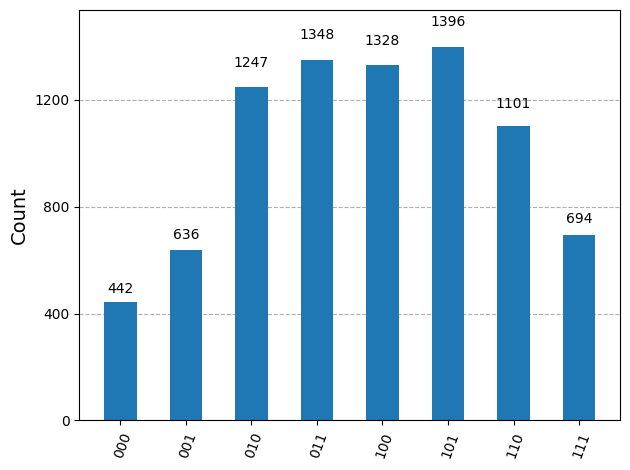

In [35]:
dim = len(state_dict[1]) # dimension of 1-simplex space
prob = counts.get("0"*num_eval_qubits)/shots # probability of eigenvalue 0

print('The number of 1-holes is', dim * prob)
plot_histogram(counts)

We obtain a result of $\sim 0.52$ 1-dimensional holes. Similar results were obtained from several runs of the algorithm on the real quantum hardware. Hence, the number of holes is, unfortunately, not correctly discovered.

As the algorithmon fails to converge with real quantum hardware, a more hardware efficient ansatz needs to be developed. No optimization of the circuit was conducted due to time reasons, but we see a large potential in circuit optimization.

In [10]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}